# Problem Statement : 
Instacart, a popular online grocery delivery service, wants to optimize its operations and improve the overall customer experience. To achieve this, it is crucial to understand the diverse customer base and segment them effectively. Traditional methods of manually categorizing customers are time-consuming and may not capture the complexity of customer preferences.

# Objective:
The objective of this project is to use K-means clustering to segment Instacart's customers based on their purchasing behavior and preferences.

1-Enhanced Customer Understanding

2-Personalized Marketing Strategies

3-Efficient Resource Allocation

4-Churn Prediction and Retention

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
#pd.set_option('max_columns', 150)

#import gc
#import os

# matplotlib and seaborn for plotting
import matplotlib
#matplotlib.rcParams['figure.dpi'] = 120 #resolution
#matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
#color = sns.color_palette()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA



## Reading Data

In [2]:
aisles = pd.read_csv( 'aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv( 'order_products__prior.csv')
products = pd.read_csv('products.csv')

In [3]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Data Description
order_id: The unique identifier for an order.

product_id: The unique identifier for a product.

add_to_cart_order: Represents the sequence number of the product added to the cart in the given order. For example, if a user added five products to their cart in a particular order, this column would contain values from 1 to 5 indicating the order in which the products were added.

reordered: Indicates whether the product has been reordered in a subsequent order. A value of 1 indicates that the product has been reordered, while a value of 0 indicates that it has not been reordered.

In [4]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### Data Description

order_id: A unique identifier for each order made by a user.

user_id: A unique identifier for each user.

eval_set: Indicates whether the order is part of the "prior," "train," or "test" set. In this case, all orders are labeled as "prior," indicating they are from a user's order history before the current order being analyzed.

order_number: Represents the sequence number of the order made by a user. For example, if a user has made five orders, this column would contain values from 1 to 5 indicating the order sequence.

order_dow: Represents the day of the week when the order was placed, where 0 is Sunday and 6 is Saturday.

order_hour_of_day: Indicates the hour of the day when the order was placed, ranging from 0 to 23.

days_since_prior_order: Indicates the number of days that have elapsed since the user's previous order. This column contains NaN (Not a Number) for the first order of each user since there is no prior order to calculate the days since.

In [14]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


We will be merging the files to get a single tabular data file

In [15]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape

(32434489, 15)

In [19]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [21]:
order_products.user_id.nunique()

206209

## Segmentation

To gain insights into the relationship between users and aisles, a cross-tabulation (also known as a contingency table) is created using the pd.crosstab() function. This function calculates the frequency distribution of occurrences for each combination of user IDs and aisles. The resulting cross-tabulation table provides a summarized view of how users are associated with different aisles.

In [13]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [23]:
cross_df.tail()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
206205,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
206206,0,4,0,0,0,0,4,1,0,0,...,1,0,0,0,0,1,0,1,0,0
206207,0,0,0,0,1,0,0,0,0,0,...,3,4,0,2,1,0,0,11,0,15
206208,0,3,0,0,3,0,4,0,0,0,...,5,0,0,7,0,0,0,0,0,33
206209,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3


For comparison across users, reducing bias from varying user activity levels and facilitating clustering and analysis.

Normalization is performed by dividing each value in the table by the sum of values along the specified axis. In this case, cross_df.sum(axis=1) calculates the sum of values for each user across all aisles. Dividing each user's aisle frequencies by their respective sum of frequencies normalizes the data to represent the proportion of each aisle's contribution to a user's overall shopping behavior.

In [24]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,...,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.0,0.000000
5,0.0,0.054054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.081081


In [25]:
df.shape

(206209, 134)

### PCA and K-Means Clustering



## Variance Plot for determinig the dimensions of PCA components 

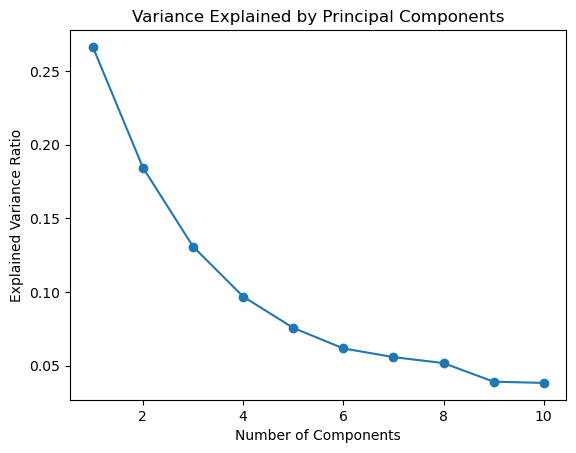

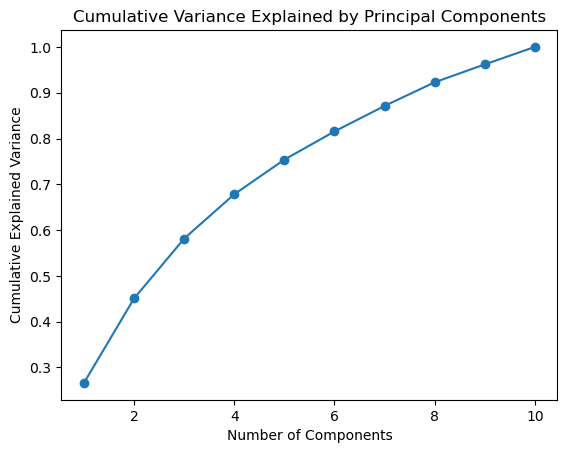

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming df_pca is the DataFrame containing the transformed data after PCA

# Initialize PCA with the desired number of components
pca = PCA(n_components=df_pca.shape[1])

# Fit PCA on the data
pca.fit(df_pca)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance ratio
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Principal Components')
plt.show()

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained by Principal Components')
plt.show()


As per the variance plot,reducing this dataframe to only 10 dimensions as KMeans does not work properly in higher dimension. 

In [34]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018866,-0.088338,-0.104538,-0.116461,0.083648,-0.062702,-0.025760
1,-0.036988,0.108884,-0.066406,-0.123271,0.098849,-0.033962,-0.054729,-0.053352,-0.020222,-0.008125
2,0.064282,0.103962,0.000710,-0.012220,-0.046976,0.112245,-0.029817,0.007797,0.011365,0.001634
3,-0.093210,0.054093,0.001867,-0.003974,-0.071357,-0.019283,-0.025116,-0.038237,0.006639,-0.000682
4,0.094629,-0.037051,-0.024952,-0.021574,0.055370,0.107650,-0.008046,0.103920,0.051642,-0.025775


In [28]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

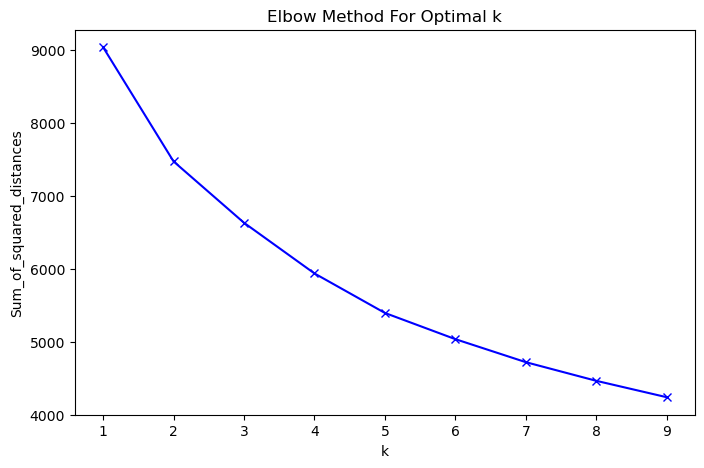

In [29]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above plot we can choose optimal K as 5

In [30]:
clusterer = KMeans(n_clusters=5,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[-6.14576091e-03  1.30681530e-01  4.86043359e-03  2.30150207e-01
   1.10161077e-01 -2.27767995e-02  9.19208399e-05 -6.40032434e-03
   7.84650287e-03  3.05270833e-03]
 [ 6.76159216e-02  1.05941823e-01 -1.11698515e-03 -3.09449235e-02
  -1.07518705e-02  7.18383108e-03 -5.25802462e-04  4.50990216e-03
  -7.05594442e-04 -1.58465257e-04]
 [-1.98274645e-01  1.61778114e-02  3.17235433e-01 -3.14082768e-02
   1.87338570e-02  6.18524021e-04  4.05890720e-03  1.08865322e-02
   1.14928389e-03 -3.86495850e-03]
 [-7.38942544e-02 -1.05670962e-02 -2.70078290e-02 -7.00877823e-03
  -6.75259939e-03  1.54687283e-03  5.03689149e-04 -2.53106057e-03
  -3.20703058e-04 -4.07977270e-04]
 [ 1.05527611e-01 -7.30605991e-02  1.72470676e-02  3.66885652e-03
   1.76763109e-03 -4.42376338e-03 -9.45012865e-04  1.29755370e-03
  -1.81370260e-04  7.71700097e-04]]


#### Visualizing clustering among first two principal components

In [31]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

C:\Users\p4pre\AppData\Local\Temp\ipykernel_5240\1558269435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['cluster'] = c_preds


,pc1,pc2,cluster
0,-0.113443,0.039084,3
1,-0.036988,0.108884,1
2,0.064282,0.103962,1
3,-0.093210,0.054093,3
4,0.094629,-0.037051,4


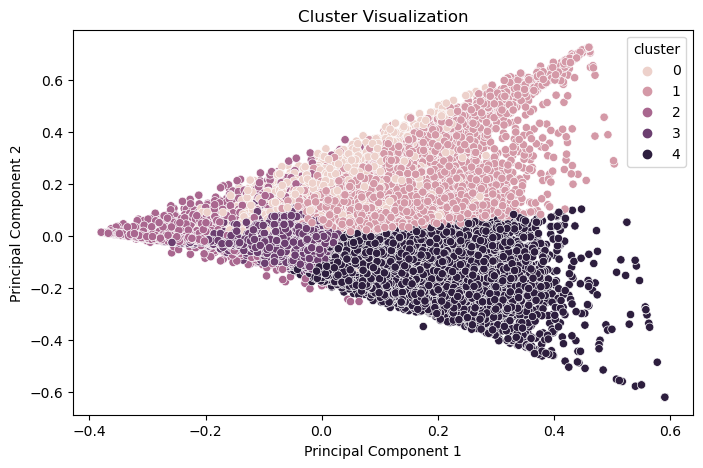

In [35]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

### Top products per cluster

In [36]:
cross_df['cluster'] = c_preds

cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]
cluster5 = cross_df[cross_df.cluster == 4]

In [37]:
cluster1.shape

(7948, 135)

In [38]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
packaged produce                 18.356442
fresh fruits                     10.873427
packaged vegetables fruits        4.242199
fresh vegetables                  3.108455
water seltzer sparkling water     1.714771
milk                              1.614872
packaged cheese                   1.548691
frozen produce                    1.144942
chips pretzels                    1.139280
nuts seeds dried fruit            1.033090
dtype: float64

In [39]:
cluster2.shape

(37857, 135)

In [40]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     35.760361
fresh vegetables                 15.030140
packaged vegetables fruits       12.096970
yogurt                            9.879203
milk                              5.956124
packaged cheese                   5.112080
soy lactosefree                   3.776897
water seltzer sparkling water     3.614127
bread                             3.196054
chips pretzels                    3.130148
dtype: float64

In [41]:
cluster3.shape

(5414, 135)

In [42]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    20.950683
fresh fruits                      3.336535
soft drinks                       2.800702
yogurt                            2.254895
energy granola bars               1.557074
chips pretzels                    1.346694
milk                              1.327484
tea                               1.327115
packaged vegetables fruits        1.251201
soy lactosefree                   1.082564
dtype: float64

In [43]:
cluster4.shape

(99147, 135)

In [44]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     9.777068
fresh vegetables                 7.575176
yogurt                           7.225080
packaged vegetables fruits       6.002794
packaged cheese                  4.931506
chips pretzels                   4.482445
milk                             4.255338
water seltzer sparkling water    4.091309
refrigerated                     3.257264
ice cream ice                    3.098359
dtype: float64

In [45]:
cluster5.shape

(55843, 135)

In [46]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 37.034740
fresh fruits                     21.749458
packaged vegetables fruits       12.028508
yogurt                            6.161220
packaged cheese                   5.020110
fresh herbs                       4.150511
milk                              4.004226
soy lactosefree                   3.705657
frozen produce                    3.302813
water seltzer sparkling water     3.080350
dtype: float64

## Evaluation Metrics

In [48]:
from sklearn.metrics import silhouette_score

# Assuming df_pca is the DataFrame containing the transformed data after PCA
# Assuming c_preds contains the cluster labels assigned by K-means

# Calculate the silhouette score
silhouette_avg = silhouette_score(df_pca, c_preds)

# Print the silhouette score
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.21893204029302535


# Conclusion

Customer Segmentation Results:



- Cluster 1 results into 7948 consumers having a very strong preference for packaged produce followed by fresh fruits aisle.
- Cluster 2 results into 37857 consumers who mostly order fresh fruits followed by vegetables.
- Cluster 3 results into 5414 consumers who buy water seltzer sparkling water and fresh fruits mostly.
- Cluster 4 results into 99147 consumers who have a very strong preference for fruits followed by fresh vegetables.
- Cluster 5 results into 55843 consumers who orders products from many aisles. 
- Cluster 3's mean orders are low compared to other clusters which tells us that either they are not frequent users of Instacart or they are new users and do not have many orders yet. 